# Algorithms

This document provides a high level description of the algorithms implemented within MatrixProfile. Runtime comparisons are also explored when appropriate.

## Compute - MatrixProfile and Pan-MatrixProfile

There are two types of algorithm implementations to be aware of:

1. **exact** - an algorithm that computes the exact solution. The algorithm must complete before an answer is provided. The majority of the algorithms implemented are exact:

    * **stomp** - the first exact algorithm to compute the Matrix Profile.
    * **mpx** - a very fast algorithm that does not require fourier transform to compute the Matrix Profile.
    * **brute_force_pmp** - a naive Pan-MatrixProfile implementation that is inefficent.


2. **anytime** - an algorithm that may provide an approximate solution. Note that we currently do not support interactivity to stop the algorithm from running. The "anytime" component is implemented by specifying the desired percentage of samples to compute.

    * **prescrimp** - computes the Matrix Profile in a stepping fashion based on 1/4 * window size.
    * **scrimp_plus_plus** - refines solutions of prescrimp for an anytime Matrix Profile calculation.
    * **skimp** - an efficient Pan-MatrixProfile algorithm.

## Runtime Benchmarks

In this section we explore runtimes of the algorithms based on varying time series length (N) and varying window sizes (M). The hardware specifications of this runtime is displayed below and will vary across different configurations.

Note that comparisons are made between the MatrixProfile implementations only. Pan-MatrixProfile algorithms are built on top of these implementations and purely compute many MatrixProfiles over varying windows. For a fair comparison, anytime algorithms are forced to compute the exact solution.

The following benchmarks were ran on:
* Ubuntu 19.10
* Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
* 32 GB memory

In [1]:
import timeit
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Single-Threaded Varying N

This benchmark compares all algorithms, including the anytime implementations, with one CPU core. The window size (M) is held constant at 32.

In [2]:
results = {
    'Algorithm': [],
    'N': [],
    'Time (seconds)': [],
}
algorithms = [
    'stomp',
    'mpx',
    'prescrimp',
    'scrimp_plus_plus',
]
m = 2**5

for algorithm in algorithms:
    for i in range(10, 16):
        n = 2**i
        setup = [
            'import numpy as np',
            'import matrixprofile as mp',
            'ts = np.random.uniform(size={})'.format(n),
            'm = {}'.format(m),
        ]
        setup_code = ';'.join(setup)
        
        runtime_code = 'mp.algorithms.{}(ts, m)'.format(algorithm)
        
        # force anytime algorithms to compute exact solution
        if algorithm in ('prescrimp', 'scrimp_plus_plus'):
            runtime_code = 'mp.algorithms.{}(ts, m, sample_pct=1.0)'.format(algorithm)

        try:
            result = timeit.timeit(stmt=runtime_code, setup=setup_code, number=1)
        except:
            result = np.nan
        
        results['Algorithm'].append(algorithm)
        results['N'].append(n)
        results['Time (seconds)'].append(result)

In [3]:
df = pd.DataFrame(results)

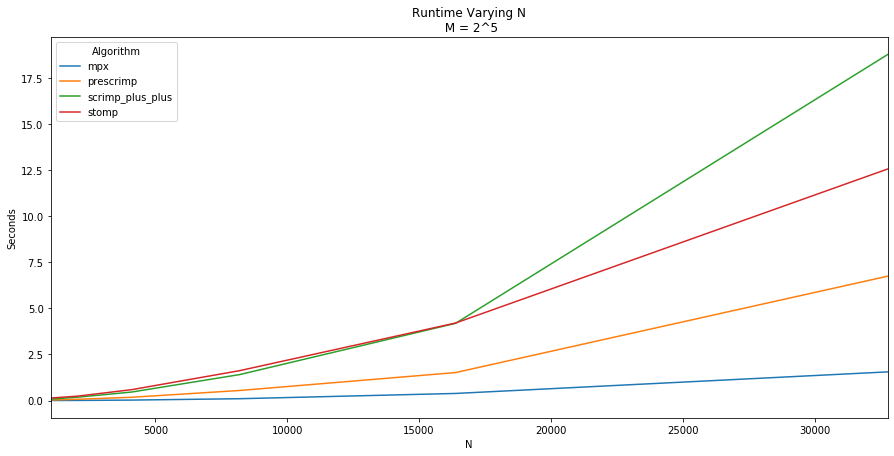

In [4]:
df.pivot(index='N', columns='Algorithm', values='Time (seconds)').plot(title='Runtime Varying N\n M = 2^5', figsize=(15,7))
plt.ylabel('Seconds')
plt.show()

In [5]:
df.pivot(index='N', columns='Algorithm', values='Time (seconds)')

Algorithm,mpx,prescrimp,scrimp_plus_plus,stomp
N,,,,
1024,0.001757,0.029654,0.075022,0.136062
2048,0.006199,0.068821,0.182622,0.239098
4096,0.024315,0.176737,0.460083,0.589630
8192,0.098919,0.545312,1.407748,1.621021
16384,0.384985,1.518244,4.192007,4.207855
32768,1.554985,6.748916,18.780976,12.567574


### Multi-Threaded Varying N

This benchmark compares all algorithms, mpx and stomp, that have parallel implementations. The window size (M) is held constant at 32.

In [6]:
results = {
    'Algorithm': [],
    'N': [],
    'Time (seconds)': [],
}
algorithms = [
    'stomp',
    'mpx',
]
m = 2**5

for algorithm in algorithms:
    for i in range(10, 16):
        n = 2**i
        setup = [
            'import numpy as np',
            'import matrixprofile as mp',
            'ts = np.random.uniform(size={})'.format(n),
            'm = {}'.format(m),
        ]
        setup_code = ';'.join(setup)
        
        runtime_code = 'mp.algorithms.{}(ts, m, n_jobs=4)'.format(algorithm)
        
        try:
            result = timeit.timeit(stmt=runtime_code, setup=setup_code, number=1)
        except:
            result = np.nan
        
        results['Algorithm'].append(algorithm)
        results['N'].append(n)
        results['Time (seconds)'].append(result)

In [7]:
df = pd.DataFrame(results)

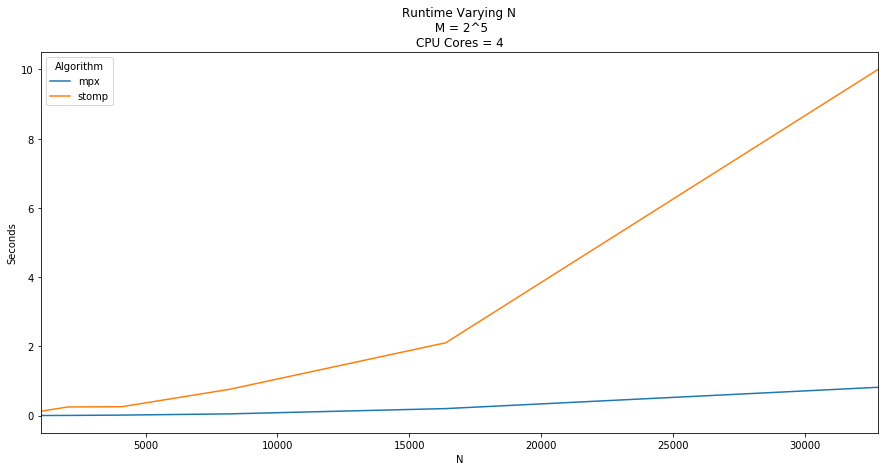

In [8]:
df.pivot(index='N', columns='Algorithm', values='Time (seconds)').plot(title='Runtime Varying N\n M = 2^5\nCPU Cores = 4', figsize=(15,7))
plt.ylabel('Seconds')
plt.show()

In [9]:
df.pivot(index='N', columns='Algorithm', values='Time (seconds)')

Algorithm,mpx,stomp
N,,
1024,0.001193,0.123515
2048,0.003401,0.248056
4096,0.012696,0.254736
8192,0.048492,0.759632
16384,0.201252,2.103931
32768,0.816059,9.997659


### Single-Threaded Varying M

This benchmark compares all algorithms, including the anytime implementations, with one CPU core. The series size (N) is held constant at 2^15.

In [10]:
results = {
    'Algorithm': [],
    'M': [],
    'Time (seconds)': [],
}
algorithms = [
    'stomp',
    'mpx',
    'prescrimp',
    'scrimp_plus_plus',
]
n = 2**15

for algorithm in algorithms:
    for i in range(5, 16):
        m = 2**i
        setup = [
            'import numpy as np',
            'import matrixprofile as mp',
            'ts = np.random.uniform(size={})'.format(n),
            'm = {}'.format(m),
        ]
        setup_code = ';'.join(setup)
        
        runtime_code = 'mp.algorithms.{}(ts, m)'.format(algorithm)
        
        # force anytime algorithms to compute exact solution
        if algorithm in ('prescrimp', 'scrimp_plus_plus'):
            runtime_code = 'mp.algorithms.{}(ts, m, sample_pct=1.0)'.format(algorithm)

        try:
            result = timeit.timeit(stmt=runtime_code, setup=setup_code, number=1)
        except:
            result = np.nan
        
        results['Algorithm'].append(algorithm)
        results['M'].append(m)
        results['Time (seconds)'].append(result)

In [11]:
df = pd.DataFrame(results)

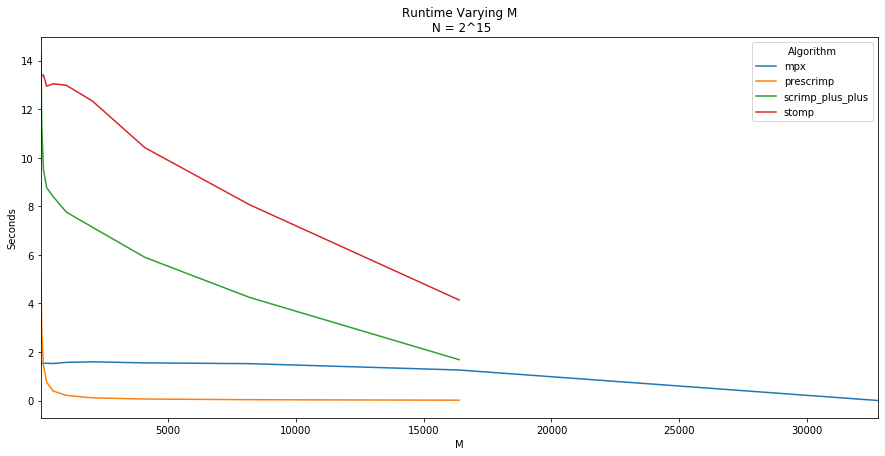

In [12]:
df.pivot(index='M', columns='Algorithm', values='Time (seconds)').plot(title='Runtime Varying M\n N = 2^15', figsize=(15,7))
plt.ylabel('Seconds')
plt.show()

In [13]:
df.pivot(index='M', columns='Algorithm', values='Time (seconds)')

Algorithm,mpx,prescrimp,scrimp_plus_plus,stomp
M,,,,
32,1.542865,5.318786,14.245731,13.244420
64,1.526071,2.829714,11.322351,13.371113
128,1.531585,1.472558,9.523658,13.406355
256,1.532456,0.750691,8.764534,12.943933
512,1.523352,0.390036,8.395955,13.041736
1024,1.570149,0.210468,7.758907,12.980969
2048,1.593238,0.108608,7.134549,12.330609
4096,1.549784,0.061189,5.896495,10.411182
8192,1.517890,0.033622,4.244812,8.062553
